# Advanced Training Optimization using Lightning

Your team has been tasked with optimizing the memory footprint of your deep learning models. With GPU memory being one of the most expensive resources in your infrastructure budget, your manager has requested solutions to reduce peak memory usage without compromising model performance.

This lab guides you through implementing and evaluating two powerful memory optimization techniques: **Mixed Precision Training** and **Gradient Accumulation**. These methods can significantly reduce GPU memory consumption while maintaining model accuracy, potentially leading to substantial cost savings in your ML infrastructure.

Beyond the optimizations themselves, this notebook will deepen your understanding of the Lightning framework. You will see how to use core components like the `Trainer` and `Callbacks` to structure and control your training process.

By the end of this lab, you will have built a complete framework to:
* **Build a custom `Callback`** to reliably measure key performance metrics like peak GPU memory and validation accuracy.
* **Encapsulate the core training logic** by configuring the Lightning `Trainer` with memory-efficient parameters.
* **Systematically benchmark** the different techniques against a baseline to gather empirical data.
* **Analyze the trade-offs** between memory usage and model performance to make data-driven decisions.

## Imports

In [1]:
import sys
import time
import warnings

# Redirect stderr to a black hole to catch other potential messages
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from lightning.pytorch.callbacks import Callback
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision import datasets, transforms

import helper_utils

torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", category=UserWarning)

## Defining the Data and Model with Lightning

Before you can benchmark different optimization techniques, you need to define the data pipeline and model architecture. As in the previous lab, you'll use `LightningDataModule` and `LightningModule` to set up these necessary components.

### `LightningDataModule` for CIFAR-10

* Define the `CIFAR10DataModule` class that handles downloading, preparing, and loading the CIFAR-10 dataset.

In [3]:
class CIFAR10DataModule(pl.LightningDataModule):
    """A LightningDataModule for the CIFAR10 dataset."""

    def __init__(self, data_dir='../data', batch_size=128, num_workers=0):
        """
        Initializes the DataModule.

        Args:
            data_dir (str): Directory to store the data.
            batch_size (int): Number of samples per batch.
            num_workers (int): Number of subprocesses for data loading.
        """
        # Call the constructor of the parent class (LightningDataModule).
        super().__init__()
        # Store the data directory path.
        self.data_dir = data_dir
        # Store the batch size for the DataLoaders.
        self.batch_size = batch_size
        # Store the number of worker processes for data loading.
        self.num_workers = num_workers
        # Define a sequence of transformations to be applied to the images.
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        """Downloads the CIFAR10 dataset if not already present."""
        
        # Download the training split of CIFAR10.
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        # Download the testing split of CIFAR10.
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """
        Assigns train/val datasets for use in dataloaders.

        Args:
            stage (str, optional): The stage of training (e.g., 'fit', 'test').
                               The Lightning Trainer requires this argument, but it is not
                               utilized in this implementation as the setup logic is the
                               same for all stages. Defaults to None.
        """
        
        # Create the training dataset instance and apply the transformations.
        self.cifar_train = datasets.CIFAR10(self.data_dir, train=True, transform=self.transform)
        # Create the validation dataset instance (using the test set) and apply transformations.
        self.cifar_val = datasets.CIFAR10(self.data_dir, train=False, transform=self.transform)
    
    def train_dataloader(self):
        """Returns the DataLoader for the training set."""
        # The DataLoader handles batching, shuffling, and parallel data loading.
        return DataLoader(self.cifar_train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        """Returns the DataLoader for the validation set."""
        # Shuffling is not necessary for the validation set.
        return DataLoader(self.cifar_val, batch_size=self.batch_size, num_workers=self.num_workers)

### `LightningModule` for the CNN Model

* Define the `CIFAR10LightningModule` class.
    * You will use the *efficient* model configuration identified in the profiling lab (`conv_channels=(32, 64, 128)` and `linear_features=512`), as it provides a much better performance baseline.

In [4]:
class CIFAR10LightningModule(pl.LightningModule):
    """A flexible LightningModule for CIFAR10 image classification."""

    def __init__(self, 
                 learning_rate=1e-3, 
                 weight_decay=0.01,
                 conv_channels=(32, 64, 128),
                 linear_features=512,
                 num_classes=10):
        """
        Initializes the LightningModule with configurable layer parameters.

        Args:
            learning_rate: The learning rate for the optimizer.
            weight_decay: The weight decay (L2 penalty) for the optimizer.
            conv_channels: A tuple specifying the output channels for each
                           convolutional block.
            linear_features: The number of features in the hidden fully
                             connected layer.
            num_classes: The number of output classes for the classification task.
        """
        # Call the constructor of the parent class.
        super().__init__()
        # Save the hyperparameters passed to the constructor.
        self.save_hyperparameters()
        
        # Calculate the flattened size of the feature maps after the final
        # pooling layer. This is needed to define the input size of the
        # first fully connected layer.
        flattened_size = self.hparams.conv_channels[-1] * 4 * 4
        
        # Define the model's architecture using a sequential container.
        self.model = nn.Sequential(
            nn.Conv2d(3, self.hparams.conv_channels[0], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.hparams.conv_channels[0], self.hparams.conv_channels[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.hparams.conv_channels[1], self.hparams.conv_channels[2], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(flattened_size, self.hparams.linear_features),
            nn.ReLU(),
            nn.Linear(self.hparams.linear_features, self.hparams.num_classes)
        )
        
        # Initialize the loss function.
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Initialize metrics to track accuracy for training and validation.
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.hparams.num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor containing a batch of images.

        Returns:
            The output tensor (logits) from the model.
        """
        # Pass the input through the sequential model.
        return self.model(x)

    def training_step(self, batch, batch_idx=None):
        """
        Performs a single training step.
    
        Args:
            batch (Any): The data batch from the dataloader.
            batch_idx (int, optional): The index of the current batch. The Lightning Trainer
                                     requires this argument, but it is not utilized in this
                                     implementation. Defaults to None.
        """
        # Unpack the batch into inputs (images) and labels.
        inputs, labels = batch
        # Perform a forward pass to get the model's predictions (logits).
        outputs = self(inputs)
        # Calculate the loss.
        loss = self.loss_fn(outputs, labels)

        # Log the training loss
        self.log("train_loss", loss)
        
        # Return the loss to Lightning for backpropagation.
        return loss

    def validation_step(self, batch, batch_idx=None):
        """
        Performs a single validation step.
    
        Args:
            batch (Any): The data batch from the dataloader.
            batch_idx (int, optional): The index of the current batch. The Lightning Trainer
                                     requires this argument, but it is not utilized in this
                                     implementation. Defaults to None.
        """
        # Unpack the batch into inputs (images) and labels.
        inputs, labels = batch
        # Perform a forward pass to get the model's predictions (logits).
        outputs = self(inputs)
        # Calculate the loss.
        loss = self.loss_fn(outputs, labels)

        # Log the validation loss
        self.log("val_loss", loss, prog_bar=True)
        # Update the validation accuracy metric with the current batch's results.
        self.val_accuracy(outputs, labels)
        # Log the validation accuracy
        self.log("val_accuracy", self.val_accuracy, prog_bar=True)

    def configure_optimizers(self):
        """
        Configures and returns the model's optimizer.

        Returns:
            An instance of the optimizer.
        """
        # Create and return the AdamW optimizer.
        return optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)

## Building the Benchmarking Framework

Now that the model and data are defined, you need to build a system to automate the process of running and comparing the different optimization experiments. This will involve creating a set of reusable functions and components that work together to handle everything from performance measurement to executing the training loop.

### Creating a Custom Callback for Measurement

To measure the performance of each experiment reliably, you need a consistent way to collect data. Lightning provides an elegant solution for this called <code>[Callbacks](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)</code>. A `Callback` is an object that can hook into the training process at various points, like the beginning of an epoch or the end of a training run, to execute your custom code. This is an essential tool for logging, monitoring, or in this case, performance measurement.

You will create a `PerformanceCallback` class to gather all the metrics needed for the analysis:
* **Peak memory usage**: The maximum GPU memory used at any single point during training.
* **Validation accuracy**: The model's performance on the unseen validation dataset.

* Define `PerformanceCallback`:
    * `__init__`: The constructor where you will initialize variables to store the data you collect.
    * `on_train_start` & `on_train_end`: These hooks are used for memory monitoring. `on_train_start` resets the GPU's peak memory counter, and `on_train_end` records the final peak memory usage.
    * `on_validation_epoch_end`: This hook runs after each validation epoch to save the latest validation accuracy.

In [5]:
class PerformanceCallback(Callback):
    """
    A Lightning Callback to collect key performance metrics during the training
    and validation lifecycle.

    This callback measures:
    - Validation accuracy
    - Peak GPU memory usage during training
    """

    def __init__(self):
        """Initializes storage for the performance metrics to be collected."""
        # Initialize a list to store performance metrics
        self.metrics = []
        
        # Initialize an attribute to store peak memory usage
        self.peak_memory_mb = None

    def on_train_start(self, trainer, pl_module=None):
        """
        Resets peak GPU memory statistics at the start of training.
    
        Args:
            trainer (pl.Trainer): The main Lightning Trainer instance.
            pl_module (pl.LightningModule, optional): The LightningModule being trained.
                                                     Required by the callback hook but not
                                                     utilized here. Defaults to None.
        """
        # Check if CUDA is available for GPU operations
        if torch.cuda.is_available():
            # Reset the peak memory statistics on the root device
            torch.cuda.reset_peak_memory_stats(trainer.strategy.root_device)
            # Clear the CUDA cache to free up memory
            torch.cuda.empty_cache()

    def on_validation_epoch_end(self, trainer, pl_module=None):
        """
        Aggregates and logs metrics at the end of a validation epoch.
    
        Args:
            trainer (pl.Trainer): The Lightning Trainer instance.
            pl_module (pl.LightningModule, optional): The LightningModule being validated.
                                                     Required by the callback hook but not
                                                     utilized here. Defaults to None.
        """
        # Check if the trainer is not in sanity checking mode
        if not trainer.sanity_checking:
            # Get the metrics collected by the trainer's callbacks
            metrics = trainer.callback_metrics
            # Append a dictionary with the validation accuracy to the metrics list
            self.metrics.append({
                "val_accuracy": metrics["val_accuracy"].item() * 100
            })

    def on_train_end(self, trainer, pl_module=None):
        """
        Records the peak GPU memory usage at the end of training.
    
        Args:
            trainer (pl.Trainer): The PyTorch Lightning Trainer instance.
            pl_module (pl.LightningModule, optional): The LightningModule that was trained.
                                                     Required by the callback hook but not
                                                     utilized here. Defaults to None.
        """
        # Check if CUDA is available for GPU operations
        if torch.cuda.is_available():
            # Get the maximum memory allocated on the root device
            peak_memory = torch.cuda.max_memory_allocated(trainer.strategy.root_device)
            # Convert the peak memory from bytes to megabytes
            self.peak_memory_mb = peak_memory / 1024**2

### The Core Training Function

To run your optimization experiments in a clean and repeatable way, you will encapsulate the main training logic into a dedicated function. This function's primary job is to configure the Lightning <code>[Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html)</code>, the component responsible for handling the entire training process.

To keep the code organized and to emphasize this core logic, you will define the `Trainer` setup in a separate `run_training` function. Each optimization experiment you run later will call this same function, just with different configuration settings.

**The Lightning Advantage**

The Lightning `Trainer` is the main event; it completely automates and handles the entire training process. This is your training loop. You can forget writing `for` loops, manually moving data to the GPU, and calling `.zero_grad()`, `.backward()`, and `.step()`. The Trainer orchestrates everything. You simply configure it and call `.fit()`.

#### Encapsulating the Training Run

* Define the `run_training` function, which contains the complete logic for a training run. It initializes a `Trainer`, runs `.fit()`, and then returns the `trainer` object, containing all the state and results from the training.
    * `precision`:  Controls the numerical precision for training (e.g., `'16-mixed'` to enable mixed precision).
    * `accumulate_grad_batches`: Specifies the number of batches to process before updating the model's weights, enabling gradient accumulation.
    * `callbacks`: Takes a list of `Callback` objects. You will pass your `PerformanceCallback` here to collect metrics during the run.
* Returning the `trainer` is important because it contains all the state and results from the run.

In [6]:
def run_training(model, data_module, num_epochs, precision, grad_accum, performance_callback):
    """
    Configures and runs a Lightning training process.

    Args:
        model (pl.LightningModule): The model to be trained.
        data_module (pl.LightningDataModule): The data module that provides the datasets.
        num_epochs (int): The total number of epochs for training.
        precision (str): The numerical precision for training ('32-true', '16-mixed').
        grad_accum (int): The number of batches to accumulate gradients over.
        performance_callback (pl.Callback): A callback to measure performance metrics.

    Returns:
        pl.Trainer: The trainer instance after fitting is complete.
    """
    
    # Initialize a Lightning Trainer with specific parameters
    trainer = pl.Trainer(
        max_epochs=num_epochs,               # Set the maximum number of training epochs
        accelerator="auto",                  # Automatically select the best accelerator (e.g., CPU, GPU)
        devices=1,                           # Use a single device for training
        precision=precision,                 # Set the numerical precision for the training process
        accumulate_grad_batches=grad_accum,  # Configure the number of batches to accumulate gradients before updating weights
        callbacks=[performance_callback],    # Provide a list of callbacks to be used during training
        logger=False,                        # Disable logging for this training run
        enable_progress_bar=True,            # Enable the progress bar to show training progress
        enable_model_summary=False,          # Disable the model summary
        enable_checkpointing=False           # Disable model checkpointing
    )
    
    # Start the training process using the provided model and data module
    trainer.fit(model, data_module)
    
    # Return the configured and trained trainer instance
    return trainer

### Orchestrating the Experiments

Now you will create the main `run_optimization` function. This function will manage all the necessary parts for each experiment from start to finish. It will:

* **Set up the experiment**: Create new instances of your `model` and the `PerformanceCallback`.
* **Execute the training**: Call the `run_training` function to handle the actual training process.
* **Process the results**: Extract metrics from your callback and format everything into a dictionary.
* **Return the findings**: Return the formatted results for later comparison and plotting.

In [7]:
def run_optimization(name, data_module, num_epochs, precision, grad_accum):
    """
    Orchestrates and runs a single, complete optimization experiment.

    Args:
        name (str): The display name for the experiment (e.g., "Mixed Precision").
        data_module (pl.LightningDataModule): The data module for training and validation.
        num_epochs (int): The number of epochs to train for.
        precision (str): The training precision to use ('32-true', '16-mixed').
        grad_accum (int): The number of batches for gradient accumulation.
        
    Returns:
        tuple[dict, dict]: A tuple containing two dictionaries:
        1. The summarized results for the comparison table.
        2. The detailed data required for generating plots.
    """
    
    # Set up the experiment
    print(f"\n--- Running Experiment: {name} (For {num_epochs} Epochs) ---")
    
    model = CIFAR10LightningModule()
    performance_callback = PerformanceCallback()

    # Execute the training
    trainer = run_training(
        model=model,
        data_module=data_module,
        num_epochs=num_epochs,
        precision=precision,
        grad_accum=grad_accum,
        performance_callback=performance_callback,
    )

    # Process the results
    accuracies = [m["val_accuracy"] for m in performance_callback.metrics]
    
    current_results = {
        "optimization": name,
        "final_acc": accuracies[-1],
        "peak_mem_mb": performance_callback.peak_memory_mb,
    }
    
    plot_info = {**current_results, "accuracies": accuracies}
    
    # Return the findings
    return current_results, plot_info

### Running the Optimization Experiments

With all the runner functions in place, it's time to execute the experiments. First, you'll define the shared configurations for all the upcoming experimental runs:

* `num_epochs`: Set the number of epochs for each optimization run.
* `batch_size` and `num_workers`: You will use an effective `batch_size=256` and `num_workers=4` to remain within the memory limits of this environment.
* `results[]`: An empty list to collect the final, summarized results from each experiment.
* `plot_data[]`: A second empty list to store data needed for visualizations.
* `data_module`: An instance of your `CIFAR10DataModule`, configured with the `batch_size` and `num_workers` you just defined.

In [8]:
# Set the number of epochs for each run
num_epochs = 5
# Define the number of samples to be processed in each batch
batch_size = 256
# Set the number of parallel processes for data loading
num_workers = 4

# Initialize an empty list to store the final summary results for the comparison table
results = []
# Initialize an empty list to store detailed data for generating plots
plot_data = []

# Create an instance of the DataModule, configuring it with the specified batch size and number of workers
data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

Now you will see the different training optimizations in action. You are going to run several experiments to directly compare their effects. It is important to remember that no single technique is universally better than another. Each optimization presents a distinct balance of benefits and drawbacks, making it suitable for different scenarios. Your choice will depend on what you prioritize for your project, such as achieving maximum accuracy or the most efficient use of resources.

The table below summarizes the different experiments.  Note that all experiment have the same `Effective Batch Size` of 256.

|Name|Effective Batch Size|Batch Size|Gradient Accumulation|Precision|
|:---|---|---|---|---|
|Standard|256|256|1|32-bit|
|Mixed Precision|256|256|1|16-bit|
|Gradient Accumulation (Effective BS: 256-128)|256|128|2|32-bit|
|Gradient Accumulation (Effective BS: 256-64)|256|64|4|32-bit|
|Combined (Effective BS: 256-128)|256|128|2|16-bit|
|Combined (Effective BS: 256-64)|256|64|4|16-bit|


#### Standard Training

This first run establishes your baseline. It is the standard, most direct approach to training a model. You will execute a training process without any advanced optimizations, which provides an essential reference point to fairly measure the effectiveness of the other techniques.

You should consider this the default method for any new project. It is the best choice when your primary goal is to ensure maximum numerical stability and accuracy, and when you are not constrained by training time or available GPU memory.

The primary benefit is its high precision, ensuring that all calculations are very accurate and your results are reliable. However, its main drawback is that it is resource intensive. This method uses the most memory and can be significantly slower than other techniques, especially on modern hardware designed to accelerate lower precision computations.

**Standard Precision (`32-true`)**

This setting tells the `Trainer` to perform all calculations using **full 32 bit floating point numbers**. This is the default data type for most deep learning operations and offers a high degree of numerical accuracy.

* **precision**: Set to `"32-true"`.
* **grad_accum**: Set to `1`, which means the model's weights will be updated after every single batch. This is normal, non-accumulated training behavior.

In [9]:
res, p_data = run_optimization(
    name="Standard",
    precision="32-true",
    grad_accum=1,
    data_module=data_module,
    num_epochs=num_epochs,
)

results.append(res)
plot_data.append(p_data)


--- Running Experiment: Standard (For 5 Epochs) ---


Output()

#### Mixed Precision Training

In this second run, you will explore **Mixed Precision Training**. This technique cleverly combines the use of two different numerical precisions. It aims to speed up training and reduce GPU memory usage by performing many computations using a fast **16 bit floating point** format. To maintain numerical stability, it strategically keeps critical operations, like weight updates, in the standard 32 bit format.

You should use this technique when your goal is to **train faster** or **reduce the memory footprint** of your model. The speed benefits are especially noticeable on modern GPUs with hardware designed to accelerate lower precision math. It's an excellent option for training very large models that might not otherwise fit into your GPU's memory. The potential drawback of this technique is a slight risk of reduced final accuracy due to the lower precision used in some calculations. 

**Mixed Precision (`16-mixed`)**

By setting the precision to `"16-mixed"`, you instruct Lightning to automatically handle the process. It will strategically use half precision (16 bit) for operations like matrix multiplications and full precision (32 bit) for operations where high accuracy is needed, like weight updates.

* **precision**: Set to `"16-mixed"` to enable automatic mixed precision training.
* **grad_accum**: This remains `1`, as you are only measuring the effect of mixed precision in this run.

In [10]:
res, p_data = run_optimization(
    name="Mixed Precision",
    precision="16-mixed",
    grad_accum=1,
    data_module=data_module,
    num_epochs=num_epochs,
)

results.append(res)
plot_data.append(p_data)


--- Running Experiment: Mixed Precision (For 5 Epochs) ---


Output()

#### Gradient Accumulation

Sometimes you want the benefits of reducing the batch size, to reduce GPU memory without compromising your accuracy. Gradient Accumulation is the solution for this exact problem. This technique works by processing several smaller batches one after another and adding up their gradients. Only after a set number of these small batches does your model perform a single weight update, which effectively simulates training with a much larger batch size without the high memory cost.

You should use this technique when training is unstable and you believe a larger batch size would help, but you are limited by your hardware's memory. It is a very common and effective strategy for training large models, like Transformers, that often require large batches to converge well.

The main benefit is achieving more stable training updates, which can lead to better model convergence, all while using less memory than a true large batch would require. The primary drawback, however, is that it can increase the total training time. Additionally, you should be cautious when using this technique with layers like Batch Normalization, as it can sometimes affect their performance.

**Effective Batch Size (Effective BS)**

This metric tells you the size of the batch you are simulating. The formula is:

> Effective Batch Size = batch_size * grad_accum

With a `batch_size` of 128 and `grad_accum` of 2, your effective batch size is 256.

* **precision**: Set to `"32-true"` to measure only the effect of gradient accumulation.
* **grad_accum**: Set to `2`. This tells the `Trainer` to process 2 batches before updating the model's weights.

In [11]:
# Data module setup
batch_size = 128
data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

# Gradient accumulation setup
effective_batch_size = 256
grad_accum = effective_batch_size // batch_size

res, p_data = run_optimization(
    name="Gradient Accumulation (Effective BS: 256-128)",
    precision="32-true",
    grad_accum=grad_accum,
    data_module=data_module,
    num_epochs=num_epochs,
)

results.append(res)
plot_data.append(p_data)


--- Running Experiment: Gradient Accumulation (Effective BS: 256-128) (For 5 Epochs) ---


Output()

<br>

**Your Task**

Now, perform another gradient accumulation run, with the same effective batch size of 256 but a different batch size.

* **precision**: To ensure you are only measuring the impact of gradient accumulation, which precision setting should be used? (*Hint*: not mixed precision)

* **grad_accum**: Given a `batch_size` of 64, what `grad_accum` value should you use to reach the target of 256?

In [13]:
try:
    # Data module setup
    batch_size = 64
    data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

    res, p_data = run_optimization(
        name="Gradient Accumulation (Effective BS: 256-64)",

        # Set precision for gradient accumulation
        precision="32-true",
        # Set the accumulation steps to achieve an effective batch size of 256
        grad_accum=4,

        data_module=data_module,
        num_epochs=num_epochs,
    )

    results.append(res)
    plot_data.append(p_data)

except Exception as e:
    print("\033[91mSomething went wrong, try again!")
    raise e


--- Running Experiment: Gradient Accumulation (Effective BS: 256-64) (For 5 Epochs) ---


Output()

<br>

<details>
<summary><span style="color:green;"><strong>Solution (Click here to expand)</strong></span></summary>

```python
try:
    # Data module setup
    batch_size = 64
    data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

    res, p_data = run_optimization(
        name="Gradient Accumulation (Effective BS: 256-64)",

        # Set precision for gradient accumulation
        precision="32-true",
        # Set the accumulation steps to achieve an effective batch size of 256
        grad_accum=4,

        data_module=data_module,
        num_epochs=num_epochs,
    )

    results.append(res)
    plot_data.append(p_data)

except Exception as e:
    print("\033[91mSomething went wrong, try again!")
    raise e
```

#### Combining Optimizations

For the next run, you will combine mixed precision and gradient accumulation. This is a powerful approach where you use both techniques at the same time to create a highly efficient training configuration. The goal is to see if you can get the synergistic benefits of both working together.

You should consider this combined strategy when you are facing significant constraints in GPU memory. It is especially useful for training very large, state of the art models that require a large batch size for stable convergence but are too big to fit in memory using standard precision.

The primary benefit is achieving maximum resource efficiency. Mixed precision reduces the memory footprint and speeds up computation, while gradient accumulation allows you to train with a stable, large effective batch size. The potential drawback is that the risks of each technique are combined. You must be mindful of a potential accuracy dip from mixed precision alongside the possibility of longer training times from gradient accumulation. As always, benchmarking is essential to confirm this combination yields the best overall result for your specific model and goal.

* **precision**: Set to `"16-mixed"` to leverage the speed of half precision computation.
* **grad_accum**: Set to `2` to simulate a batch size of 256.

In [14]:
# Data module setup
batch_size = 128
data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

# Gradient accumulation setup
effective_batch_size = 256
grad_accum = effective_batch_size // batch_size

res, p_data = run_optimization(
    name="Combined (Effective BS: 256-128)",
    precision="16-mixed",
    grad_accum=grad_accum,
    data_module=data_module,
    num_epochs=num_epochs,
)

results.append(res)
plot_data.append(p_data)


--- Running Experiment: Combined (Effective BS: 256-128) (For 5 Epochs) ---


Output()

<br>

**Your Task**

For the final experiment, you'll combine both optimizations again, but this time with a batch size of 64 to obtain an effective batch size of 256.

* **precision**: Since this is a combined optimization run, which precision setting should you use to get the memory benefits?

* **grad_accum**: Given a `batch_size` of 64, what `grad_accum` value should you use to reach the target effective batch size of 256?

In [15]:
try:
    # Data module setup
    batch_size = 64
    data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

    res, p_data = run_optimization(
        name="Combined (Effective BS: 256-64)",

        # Use the setting for mixed precision
        precision="16-mixed",
        # Set the accumulation steps to achieve an effective batch size of 256
        grad_accum=4,
        
        data_module=data_module,
        num_epochs=num_epochs,
    )

    results.append(res)
    plot_data.append(p_data)

except Exception as e:
    print("\033[91mSomething went wrong, try again!")
    raise e


--- Running Experiment: Combined (Effective BS: 256-64) (For 5 Epochs) ---


Output()

<br>

<details>
<summary><span style="color:green;"><strong>Solution (Click here to expand)</strong></span></summary>

```python
try:
    # Data module setup
    batch_size = 64
    data_module = CIFAR10DataModule(batch_size=batch_size, num_workers=num_workers)

    res, p_data = run_optimization(
        name="Combined (Effective BS: 256-64)",

        # Use the setting for mixed precision
        precision="16-mixed",
        # Set the accumulation steps to achieve an effective batch size of 256
        grad_accum=4,
        
        data_module=data_module,
        num_epochs=num_epochs,
    )

    results.append(res)
    plot_data.append(p_data)

except Exception as e:
    print("\033[91mSomething went wrong, try again!")
    raise e
```

### Analyzing the Results

After running all the experiments, the final step is to display and visualize the collected data to understand the trade offs between the different strategies.

* First, a summary table provides a detailed numerical look at the key metrics from every run.

In [ ]:
# Display the comparison table of all experiment results
helper_utils.optimization_results(results)

**Optimization Technique Abbreviations**

To improve readability in the visualizations, the following abbreviations are used for each optimization technique:

* **STD** - Standard
* **MP** - Mixed Precision  
* **GA256-128** - Gradient Accumulation (Effective BS: 256-128)
* **GA256-64** - Gradient Accumulation (Effective BS: 256-64)
* **Comb256-128** - Combined (Effective BS: 256-128)
* **Comb256-64** - Combined (Effective BS: 256-64)

* Next, a bar chart compares the **final accuracy** (validation) of each technique.

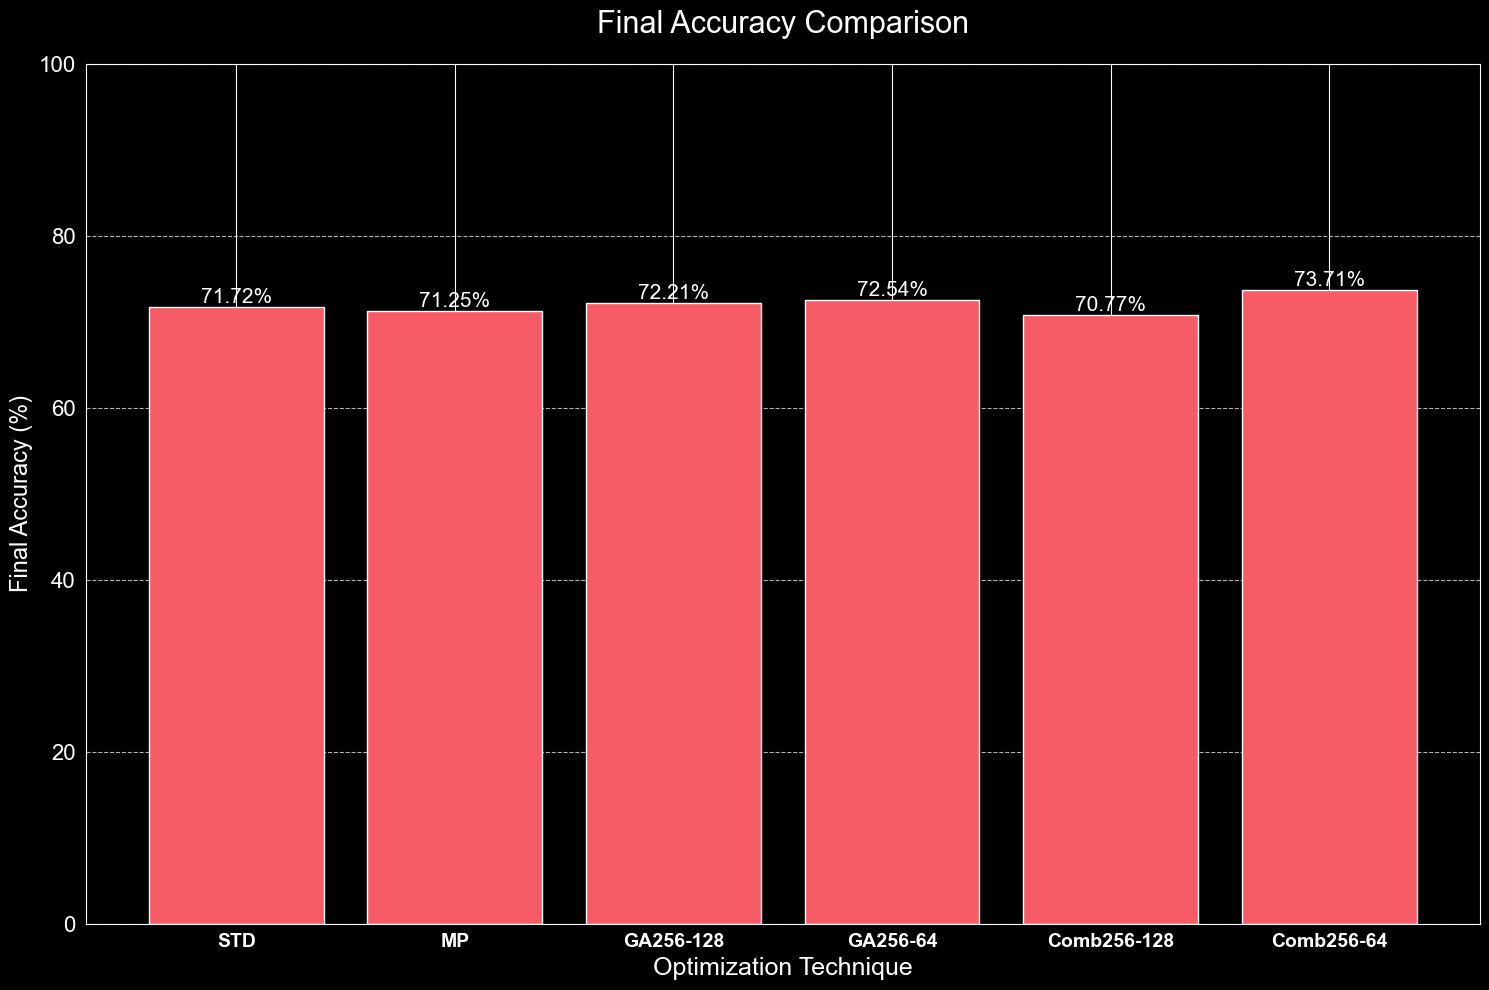

In [16]:
# Visualize the final accuracy to compare each optimization technique
helper_utils.plot_final_accuracy(results)

* The final trade off to consider is GPU memory usage. This chart visualizes the **peak memory** consumed during each run, which is critical for understanding which techniques are the most resource efficient.

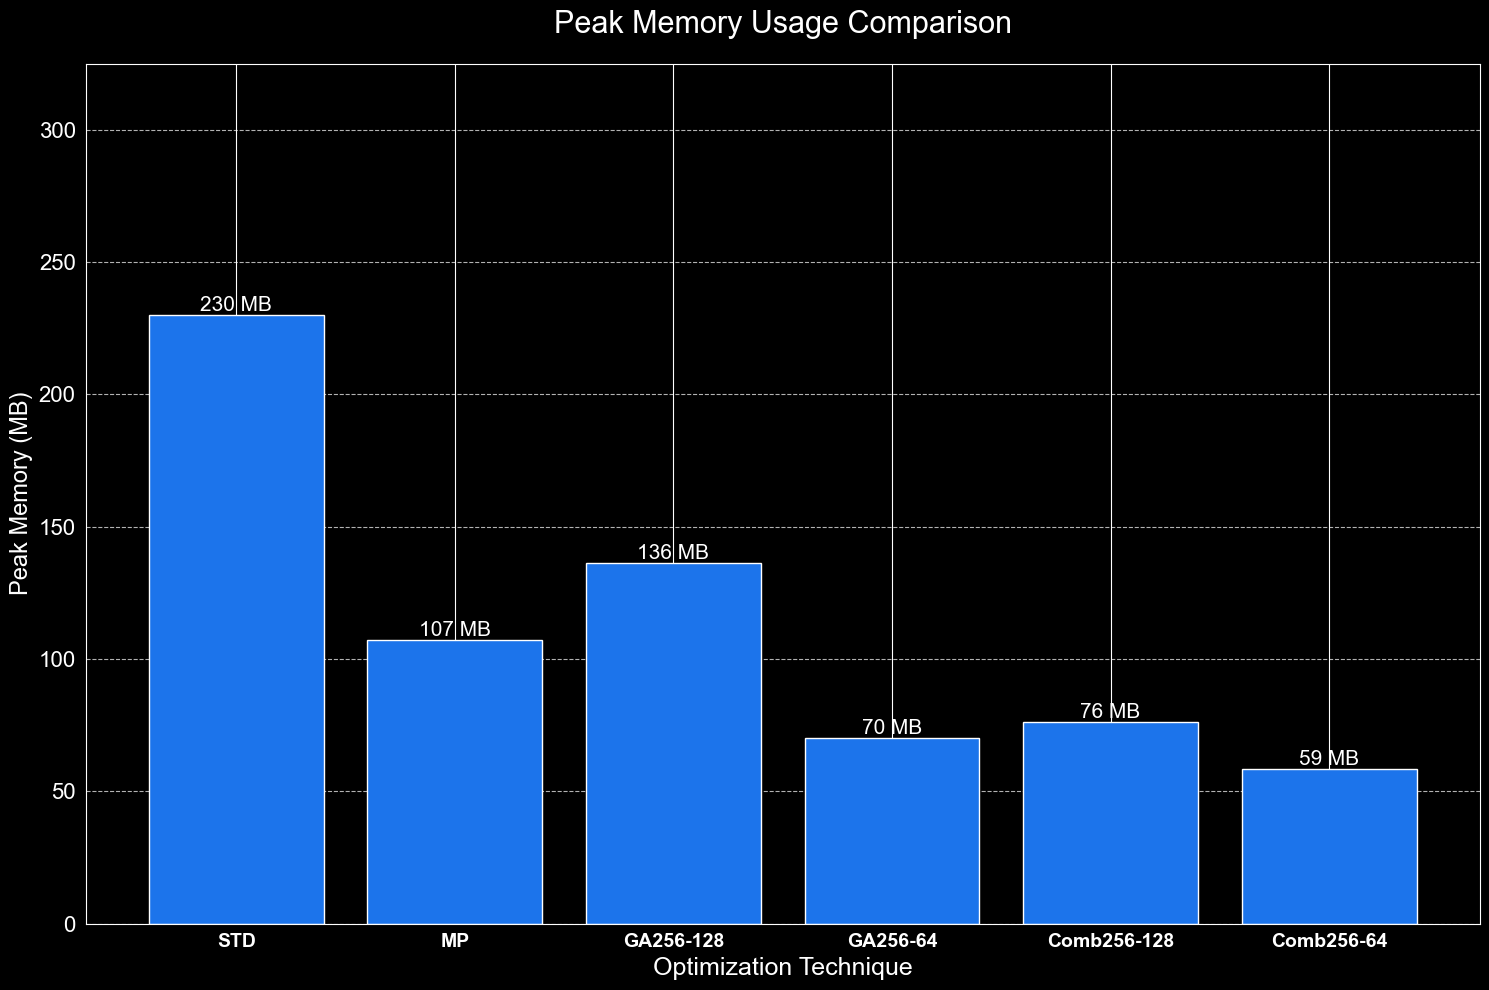

In [17]:
# Visualize the peak memory usage for each optimization
helper_utils.plot_peak_memory(results)

## Analysis

The graph above shows that Mixed Precision reduces memory usage. Likewise, using smaller batch sizes (128 and 64) while maintaining an effective batch size of 256 also lowers memory consumption. Finally, combining Gradient Accumulation with Mixed Precision reduces memory usage even further, all without compromising validation accuracy.

## Conclusion

Congratulations on completing the lab! You have successfully built a complete benchmarking framework and used it to measure the impact of powerful memory optimization techniques. The results from your experiments demonstrate how to effectively reduce peak memory usage (infrastructure costs) while maintaining model performance. 

Also, you've deepened your skills with Lightning. You've seen how to use a custom **`Callback`** for detailed monitoring and how to leverage the **`Trainer`** to enable complex memory optimizations with simple, declarative parameters.

You now have a practical, data-driven approach for making cost-effective decisions about model training. By systematically benchmarking different strategies, you can ensure you are making the most efficient use of your GPU memory budget—an essential skill for managing infrastructure costs while scaling your work to larger models and datasets.